In [77]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flight-fare-prediction-mh/Data_Train.xlsx
/kaggle/input/flight-fare-prediction-mh/Test_set.xlsx
/kaggle/input/flight-fare-prediction-mh/Sample_submission.xlsx


In [78]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
pd.set_option('display.max_column',100)

In [79]:
train=pd.read_excel(r'../input/flight-fare-prediction-mh/Data_Train.xlsx')
test=pd.read_excel(r'../input/flight-fare-prediction-mh/Test_set.xlsx')
train.shape,test.shape

((10683, 11), (2671, 10))

In [80]:
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [81]:
test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [82]:
train['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [83]:
test['Airline'].value_counts()

Jet Airways                          897
IndiGo                               511
Air India                            440
Multiple carriers                    347
SpiceJet                             208
Vistara                              129
Air Asia                              86
GoAir                                 46
Multiple carriers Premium economy      3
Vistara Premium economy                2
Jet Airways Business                   2
Name: Airline, dtype: int64

In [84]:
train[train['Route'].isnull()]
train.dropna(inplace=True)

In [85]:
train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [86]:
def preprocess(data):
    data['Journey_Day']=pd.to_datetime(data['Date_of_Journey'],format="%d/%m/%Y").dt.day
    data['Journey_Month']=pd.to_datetime(data['Date_of_Journey'],format="%d/%m/%Y").dt.month
    data['Arrival_hour']=pd.to_datetime(data['Arrival_Time']).dt.hour
    data['Arrival_minute']=pd.to_datetime(data['Arrival_Time']).dt.minute
    data['Dept_hour']=pd.to_datetime(data['Dep_Time']).dt.hour
    data['Dept_minute']=pd.to_datetime(data['Dep_Time']).dt.minute
    duration=list(data['Duration'])
    for i in range(len(duration)):
        if len(duration[i].split())!=2:
            if 'h' in duration[i]:
                duration[i]=duration[i].strip()+' 0m'
            else:
                duration[i]='0h '+duration[i]
    duration_hour=[]
    duration_min=[]
    for i in range(len(duration)):
        duration_hour.append(int(duration[i].split('h')[0]))
        duration_min.append(int(duration[i].split('m')[0].split()[-1]))
    data['Duration_hour']=duration_hour
    data['Duration_min']=duration_min
    data=data.drop(['Date_of_Journey','Additional_Info','Dep_Time','Arrival_Time','Route','Duration'],axis=1)
    stop_map={
                'non-stop':0,
                '1 stop':1,
                '2 stops':2,
                '3 stops':3,
                '4 stops':4,
                '5 stops':5
                }
    data['Total_Stops']=data['Total_Stops'].map(stop_map).astype(int)
    return data

In [87]:
train=preprocess(train)
train

,Airline,Source,Destination,Total_Stops,Price,Journey_Day,Journey_Month,Arrival_hour,Arrival_minute,Dept_hour,Dept_minute,Duration_hour,Duration_min
0,IndiGo,Banglore,New Delhi,0,3897,24,3,1,10,22,20,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,13,15,5,50,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,4,25,9,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,23,30,18,5,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,21,35,16,50,4,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,0,4107,9,4,22,25,19,55,2,30
10679,Air India,Kolkata,Banglore,0,4145,27,4,23,20,20,45,2,35
10680,Jet Airways,Banglore,Delhi,0,7229,27,4,11,20,8,20,3,0
10681,Vistara,Banglore,New Delhi,0,12648,1,3,14,10,11,30,2,40


In [88]:
train['Source'].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [89]:
test['Source'].value_counts()

Delhi       1145
Kolkata      710
Banglore     555
Mumbai       186
Chennai       75
Name: Source, dtype: int64

<Figure size 1152x432 with 0 Axes>

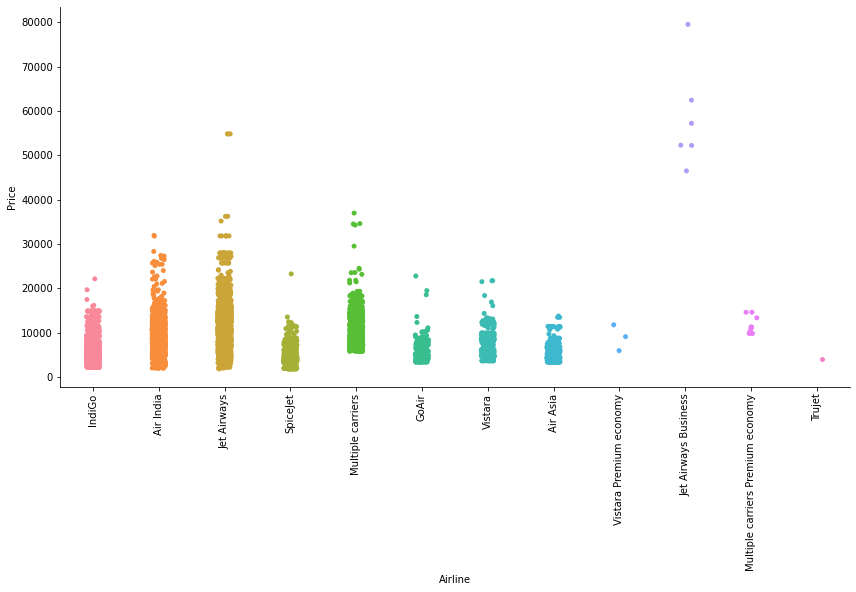

In [90]:
ax=plt.figure(figsize=(16,6))
sns.catplot(x='Airline',y='Price',data=train,height=6,aspect=2)
plt.xticks(rotation=90)
plt.show()

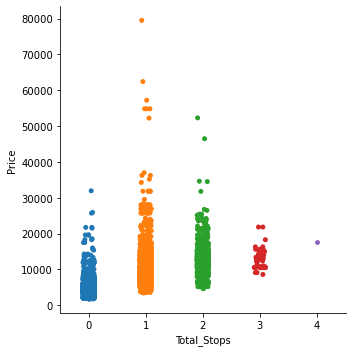

In [91]:
sns.catplot(x='Total_Stops',y='Price',data=train)

In [92]:
Source=train[['Source']]
Source=pd.get_dummies(Source,drop_first=True)
Source

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0
...,...,...,...,...
10678,0,0,1,0
10679,0,0,1,0
10680,0,0,0,0
10681,0,0,0,0


In [93]:
Airline=train[['Airline']]
Airline=pd.get_dummies(Airline,drop_first=True)
Airline

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10678,0,0,0,0,0,0,0,0,0,0,0
10679,1,0,0,0,0,0,0,0,0,0,0
10680,0,0,0,1,0,0,0,0,0,0,0
10681,0,0,0,0,0,0,0,0,0,1,0


In [94]:
Destination=train[['Destination']]
Destination=pd.get_dummies(Destination,drop_first=True)

In [95]:
train_data=pd.concat([train,Airline,Source,Destination],axis=1)
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_Day,Journey_Month,Arrival_hour,Arrival_minute,Dept_hour,Dept_minute,Duration_hour,Duration_min,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,IndiGo,Banglore,New Delhi,0,3897,24,3,1,10,22,20,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Air India,Kolkata,Banglore,2,7662,1,5,13,15,5,50,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Jet Airways,Delhi,Cochin,2,13882,9,6,4,25,9,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,23,30,18,5,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,IndiGo,Banglore,New Delhi,1,13302,1,3,21,35,16,50,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [96]:
train_data=train_data.drop(['Airline','Source','Destination'],axis=1)

In [97]:
train_data

,Total_Stops,Price,Journey_Day,Journey_Month,Arrival_hour,Arrival_minute,Dept_hour,Dept_minute,Duration_hour,Duration_min,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,1,10,22,20,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,13,15,5,50,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,13882,9,6,4,25,9,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,6218,12,5,23,30,18,5,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,13302,1,3,21,35,16,50,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0,4107,9,4,22,25,19,55,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
10679,0,4145,27,4,23,20,20,45,2,35,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
10680,0,7229,27,4,11,20,8,20,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
10681,0,12648,1,3,14,10,11,30,2,40,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [98]:
y=train_data['Price']
X=train_data.copy()
X=X.drop('Price',axis=1)

In [73]:
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,StratifiedKFold


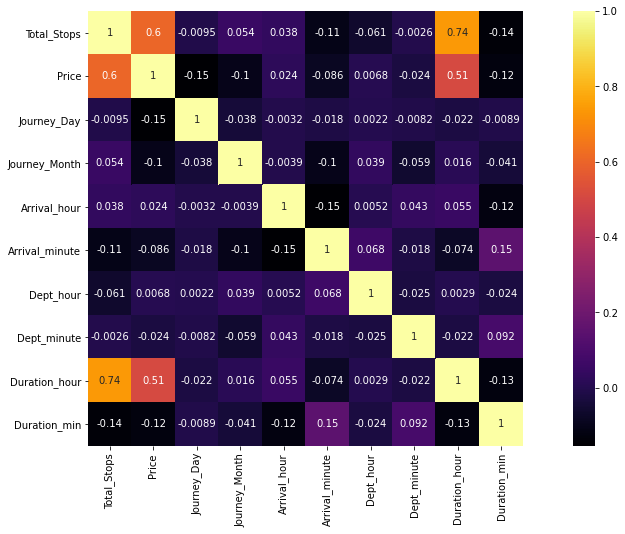

In [101]:
plt.figure(figsize=(18,8))
sns.heatmap(train.corr(),square=True,annot=True,cmap='inferno')
plt.show()

In [102]:
rf1=ExtraTreesRegressor()
rf1.fit(X,y)


ExtraTreesRegressor()

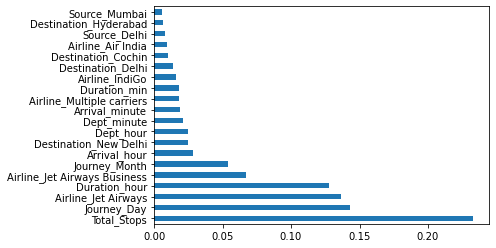

In [103]:
imp=pd.Series(rf1.feature_importances_,index=X.columns)
imp.nlargest(20).plot(kind='barh')

In [109]:
x_train,x_valid,y_train,y_valid=train_test_split(X,y,test_size=0.1,random_state=100)

In [110]:
rf2=RandomForestRegressor()
rf2.fit(x_train,y_train)

RandomForestRegressor()

In [111]:
preds=rf2.predict(x_valid)

In [112]:
rf2.score(x_valid,y_valid)

0.8242715706211609

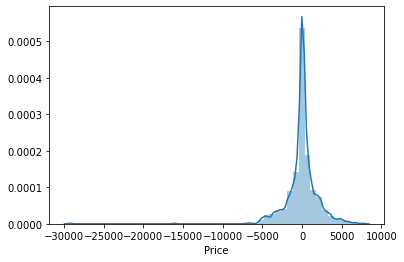

In [113]:
sns.distplot(preds-y_valid)

In [139]:
from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(y_valid,preds)))

2035.457949634243


In [130]:
n_estimators=[int(i) for i in np.linspace(start=100,stop=1600,num=30)]
max_features=['auto','sqrt','log2']
max_depth= [int(x) for x in np.linspace(start=5,stop=20,num=15)]
min_samples_leaf=[1,2,5,10]
min_samples_split=[2,5,10,15,50]
params = { 
            'n_estimators':n_estimators,
            'max_features': max_features,
            'max_depth':max_depth,
            'min_samples_leaf':min_samples_leaf,
            'min_samples_split':min_samples_split
        }

In [132]:
max_depth

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]

In [141]:
gscv=RandomizedSearchCV(estimator=rf2,param_distributions=params,n_iter=10,cv=5,scoring='neg_mean_squared_error',
                        random_state=100,n_jobs=-1)

In [142]:
gscv.fit(x_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(max_depth=11,
                                                   max_features='log2',
                                                   min_samples_split=5,
                                                   n_estimators=1000),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12,
                                                      13, 14, 15, 16, 17, 18,
                                                      20],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15, 50],
                                        'n_estimators': [100, 151, 203, 255,
                                                         306, 358, 410, 462

In [143]:
gscv.best_params_

{'n_estimators': 824,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 14}

In [144]:
gscv.best_score_

-3751796.0388044305

In [145]:
rf3=RandomForestRegressor(n_estimators=824,max_depth=14,max_features='auto',min_samples_leaf=1,min_samples_split=15)

In [146]:
rf3.fit(x_train,y_train)

RandomForestRegressor(max_depth=14, min_samples_split=15, n_estimators=824)

In [148]:
rf3.score(x_train,y_train)

0.8924055854357396

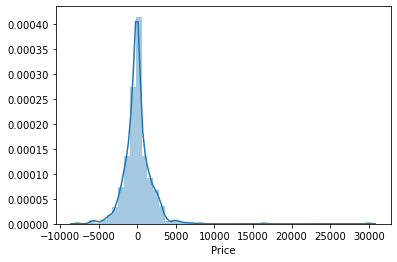

In [150]:
y_pred=rf3.predict(x_valid)
sns.distplot(y_valid-y_pred)

In [152]:
import pickle
file=open('flight.pkl','wb')


In [153]:
pickle.dump(rf3,file)